<a href="https://colab.research.google.com/github/samarthuttampalle/CC/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nltk

In [3]:
!pip install tqdm

In [4]:
!pip install pillow

In [5]:
!pip install matplotlib

In [49]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#!unzip "drive/MyDrive/Colabdata/Image-caption-generator.zip" -d "drive/MyDrive/Colabdata/"

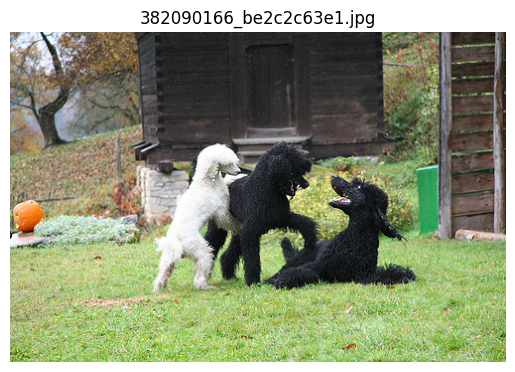

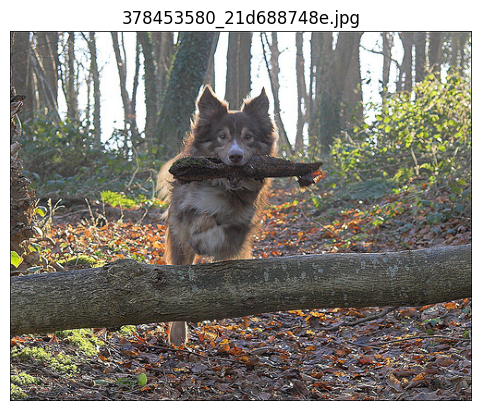

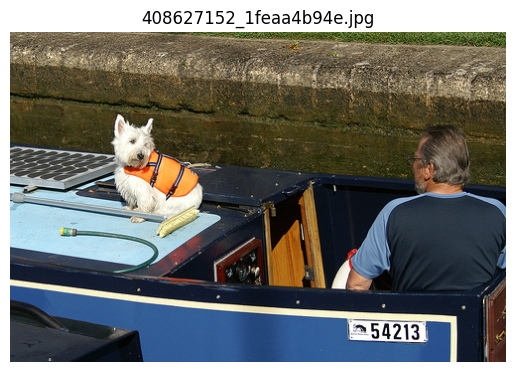

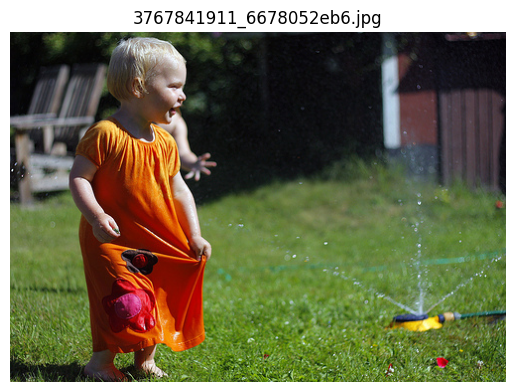

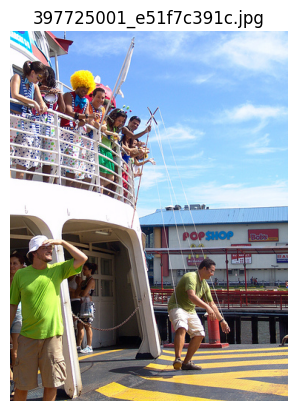

In [8]:
import os
import matplotlib.pyplot as plt
from PIL import Image

image_dir = 'drive/MyDrive/Colabdata/Images'
sample_images = os.listdir(image_dir)[:5]

for img_file in sample_images:
    img_path = os.path.join(image_dir, img_file)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_file)
    plt.show()

In [9]:
import csv

captions_file = 'drive/MyDrive/Colabdata/captions.txt'
captions_dict = {}

with open(captions_file, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header

    for row in reader:
        if len(row) != 2:
            continue  # Skip rows that don't have exactly 2 columns
        img_id, caption = row
        img_id = img_id.strip()
        caption = caption.strip()
        captions_dict.setdefault(img_id, []).append(caption)


In [10]:
sample_image = list(captions_dict.keys())[0]
print(f"Image: {sample_image}")
print("Captions:")
for i, cap in enumerate(captions_dict[sample_image]):
    print(f"{i+1}. {cap}")


Image: 1000268201_693b08cb0e.jpg
Captions:
1. A child in a pink dress is climbing up a set of stairs in an entry way .
2. A girl going into a wooden building .
3. A little girl climbing into a wooden playhouse .
4. A little girl climbing the stairs to her playhouse .
5. A little girl in a pink dress going into a wooden cabin .


## Load and Clean Captions

In [12]:
import csv
from collections import defaultdict

def load_captions_csv(filename):
    captions_dict = defaultdict(list)
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header: "image,caption"
        for row in reader:
            if len(row) == 2:
                image_id, caption = row
                captions_dict[image_id.strip()].append(caption.strip())
    return captions_dict

caption_path = 'drive/MyDrive/Colabdata/captions.txt'  # or .csv if that's the true extension
captions_dict = load_captions_csv(caption_path)
print(f"✅ Loaded captions for {len(captions_dict)} unique images.")


✅ Loaded captions for 8094 unique images.


In [13]:
import re
def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r"[^a-z ]", "", caption)  # Remove punctuation
    caption = re.sub(r"\s+", " ", caption)     # Remove multiple spaces
    return caption.strip()

# Clean all captions and add special tokens
for img in captions_dict:
    captions_dict[img] = ['startseq ' + clean_caption(c) + ' endseq' for c in captions_dict[img]]

# Preview
for k in list(captions_dict.keys())[:2]:
    print(k)
    print(captions_dict[k])

1000268201_693b08cb0e.jpg
['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq', 'startseq a girl going into a wooden building endseq', 'startseq a little girl climbing into a wooden playhouse endseq', 'startseq a little girl climbing the stairs to her playhouse endseq', 'startseq a little girl in a pink dress going into a wooden cabin endseq']
1001773457_577c3a7d70.jpg
['startseq a black dog and a spotted dog are fighting endseq', 'startseq a black dog and a tricolored dog playing with each other on the road endseq', 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']


In [14]:
def find_duplicate_captions(captions_dict):
    from collections import defaultdict

    caption_counts = defaultdict(int)

    # Count occurrences of each caption
    for captions in captions_dict.values():
        for caption in captions:
            caption_counts[caption.strip().lower()] += 1  # Normalize case and whitespace

    # Filter captions that occur more than once
    duplicates = {cap: count for cap, count in caption_counts.items() if count > 1}

    print(f"Found {len(duplicates)} duplicate captions.")
    return duplicates


In [15]:
duplicates = find_duplicate_captions(captions_dict)

# Print top 5 duplicate captions
for i, (caption, count) in enumerate(duplicates.items()):
    print(f"{i+1}. '{caption}' - {count} times")
    if i == 4: break


Found 27530 duplicate captions.
1. 'startseq a black and white dog is running through the grass endseq' - 2 times
2. 'startseq a dog is running in the snow endseq' - 4 times
3. 'startseq a dog running through snow endseq' - 4 times
4. 'startseq the children are playing in the water endseq' - 4 times
5. 'startseq a dog runs through the snow endseq' - 10 times


In [16]:
def remove_global_duplicate_captions(captions_dict):
    seen = set()
    new_captions_dict = {}

    for img_id, captions in captions_dict.items():
        new_captions = []
        for caption in captions:
            normalized = caption.strip().lower()
            if normalized not in seen:
                seen.add(normalized)
                new_captions.append(caption)
        if new_captions:
            new_captions_dict[img_id] = new_captions

    return new_captions_dict


In [17]:
# Remove duplicate captions globally
captions_dict = remove_global_duplicate_captions(captions_dict)


In [18]:
all_captions = []
for caption_list in captions_dict.values():
    all_captions.extend(caption_list)

print("Total cleaned captions:", len(all_captions))


Total cleaned captions: 40123


In [35]:
len(all_captions)

40123

In [20]:
all_captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) +1

# Save tokenizer for inference later
import pickle
with open('tokenizer1.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Get caption sequences
sequences = tokenizer.texts_to_sequences(all_captions)
max_caption_length = max(len(seq) for seq in sequences)
print("Max caption length:", max_caption_length)


Max caption length: 37


In [22]:
vocab_size

8781

In [ ]:
'''import pickle

# Change the path if you want to save it in a specific folder
with open('/content/drive/MyDrive/Colabdata/tokenizer1.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Tokenizer saved successfully to 'My Drive' as tokenizer1.pkl")'''


Tokenizer saved successfully to 'My Drive' as tokenizer1.pkl


In [ ]:
'''!pip install --upgrade pip
!pip install tensorflow==2.18.0 tensorflow-text==2.18.1 --force-reinstall'''


'!pip install --upgrade pip\n!pip install tensorflow==2.18.0 tensorflow-text==2.18.1 --force-reinstall'

In [23]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from tqdm import tqdm
import pickle



In [24]:
base_model = InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)


In [29]:
'''image_dir = 'drive/MyDrive/Colabdata/Images'  # Adjust to your folder path
features = {}

for img_name in tqdm(os.listdir(image_dir)):
    img_path = os.path.join(image_dir, img_name)
    if img_path.lower().endswith('.jpg'):
        img_tensor = preprocess_image(img_path)
        feature_vector = model.predict(img_tensor, verbose=0)
        features[img_name] = feature_vector.reshape(-1)

# Save features for future use
with open('image_features.pkl', 'wb') as f:
    pickle.dump(features, f)'''


"image_dir = 'drive/MyDrive/Colabdata/Images'  # Adjust to your folder path\nfeatures = {}\n\nfor img_name in tqdm(os.listdir(image_dir)):\n    img_path = os.path.join(image_dir, img_name)\n    if img_path.lower().endswith('.jpg'):\n        img_tensor = preprocess_image(img_path)\n        feature_vector = model.predict(img_tensor, verbose=0)\n        features[img_name] = feature_vector.reshape(-1)\n\n# Save features for future use\nwith open('image_features.pkl', 'wb') as f:\n    pickle.dump(features, f)"

In [26]:
'''with open('/content/drive/MyDrive/Colabdata/tokenizer1.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('/content/drive/MyDrive/Colabdata/image_features.pkl', 'wb') as f:
    pickle.dump(features, f)'''


"with open('/content/drive/MyDrive/Colabdata/tokenizer1.pkl', 'wb') as f:\n    pickle.dump(tokenizer, f)\n\nwith open('/content/drive/MyDrive/Colabdata/image_features.pkl', 'wb') as f:\n    pickle.dump(features, f)"

## Train Test Split

In [28]:
import random

def split_captions_dict(captions_dict, train_ratio=0.9):
    # Shuffle image IDs
    image_ids = list(captions_dict.keys())
    random.shuffle(image_ids)

    # Split indices
    split_index = int(len(image_ids) * train_ratio)
    train_ids = image_ids[:split_index]
    test_ids = image_ids[split_index:]

    # Create new dictionaries
    train_dict = {img_id: captions_dict[img_id] for img_id in train_ids}
    test_dict = {img_id: captions_dict[img_id] for img_id in test_ids}

    return train_dict, test_dict

# Example usage:
train_captions_dict, test_captions_dict = split_captions_dict(captions_dict, train_ratio=0.9)

# Confirm the split
print(f"Total images: {len(captions_dict)}")
print(f"Training images: {len(train_captions_dict)}")
print(f"Testing images: {len(test_captions_dict)}")


Total images: 8093
Training images: 7283
Testing images: 810


In [31]:
import pickle

with open('drive/MyDrive/Colabdata/image_features.pkl', 'rb') as f:
    features = pickle.load(f)


In [32]:
def split_features(features, train_ids, test_ids):
    train_features = {img_id: features[img_id] for img_id in train_ids if img_id in features}
    test_features = {img_id: features[img_id] for img_id in test_ids if img_id in features}
    return train_features, test_features

# Get image IDs from the caption dicts
train_ids = list(train_captions_dict.keys())
test_ids = list(test_captions_dict.keys())

# Split features
train_features, test_features = split_features(features, train_ids, test_ids)

# Confirm the split
print(f"Total features: {len(features)}")
print(f"Train features: {len(train_features)}")
print(f"Test features: {len(test_features)}")


Total features: 8091
Train features: 7281
Test features: 810


In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Load saved features
with open('drive/MyDrive/Colabdata/image_features.pkl', 'rb') as f:
    features = pickle.load(f)

def data_generator(features, captions_dict, tokenizer, max_length, vocab_size, batch_size=64):
    while True:
        X_img, X_seq, y = [], [], []
        count = 0

        for img_name, captions in captions_dict.items():
            if img_name not in features:
                continue  # Skip if image feature not available

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_word = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_word = tf.keras.utils.to_categorical(out_word, num_classes=vocab_size)

                    X_img.append(features[img_name])
                    X_seq.append(in_seq)
                    y.append(out_word)

                    count += 1
                    if count == batch_size:
                        yield (
                            (
                                np.array(X_img, dtype=np.float32),
                                np.array(X_seq, dtype=np.int32)
                            ),
                            np.array(y, dtype=np.float32)
                        )
                        X_img, X_seq, y = [], [], []
                        count = 0



In [39]:
# Load the new tokenizer
with open('drive/MyDrive/Colabdata/tokenizer1.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

max_length = max_caption_length

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_features, train_captions_dict, tokenizer, max_length, vocab_size, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)



In [40]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(test_features, test_captions_dict, tokenizer, max_length, vocab_size, batch_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

In [45]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout


embedding_dim = 256
vocab_size = 8781  # Same as tokenizer

# Image model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Caption model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder (merge image + caption paths)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 37, 256)   │  2,247,936 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2048)      │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 37, 256)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 37)        │          0 │ input_layer_7[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    524,544 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ dropout_5[0][0],  │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256)       │          0 │ dense_4[0][0],    │
│                     │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     65,792 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8781)      │  2,256,717 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,620,301 (21.44 MB)

 Trainable params: 5,620,301 (21.44 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
total_captions = sum(len(c) for c in train_captions_dict.values())  # use only training dict
batch_size = 64
steps_per_epoch = total_captions // batch_size

# Train the model
model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    verbose=1
)

Epoch 1/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 180s 318ms/step - loss: 4.0943
Epoch 2/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 179s 318ms/step - loss: 3.9536
Epoch 3/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 178s 315ms/step - loss: 4.0542
Epoch 4/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 178s 315ms/step - loss: 3.9816
Epoch 5/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 176s 313ms/step - loss: 3.8925
Epoch 6/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 179s 317ms/step - loss: 3.7097
Epoch 7/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 179s 317ms/step - loss: 3.7860
Epoch 8/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 177s 313ms/step - loss: 3.5871
Epoch 9/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 179s 318ms/step - loss: 3.6869
Epoch 10/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 178s 316ms/step - loss: 3.5661
Epoch 11/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 179s 318ms/step - loss: 3.5445
Epoch 12/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 177s 315ms/step - loss: 3.5585
Epoch 13/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 178s 316ms/step - loss: 3.3298
Epoch 14/15
564/564 ━━━━━━━━━━━━━━━━━━━━ 178s 316ms/step - loss: 3.2758
E

In [50]:
model.save('drive/MyDrive/Colabdata/image_caption_model_v1.h5')

In [52]:
index_word = {v: k for k, v in tokenizer.word_index.items()}


In [53]:
import numpy as np

def generate_caption_beam_search(model, tokenizer, photo, max_length, beam_width=3):
    sequences = [[list(), 0.0]]

    while len(sequences[0][0]) < max_length:
        all_candidates = []
        for seq, score in sequences:
            in_text = 'startseq ' + ' '.join([index_word.get(i, '') for i in seq])
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
            yhat = model.predict([photo, sequence], verbose=0)
            top_k = np.argsort(yhat[0])[-beam_width:]

            for word in top_k:
                candidate = seq + [word]
                new_score = score - np.log(yhat[0][word] + 1e-10)  # log prob
                all_candidates.append([candidate, new_score])

        sequences = sorted(all_candidates, key=lambda tup: tup[1])[:beam_width]

    final_seq = sequences[0][0]
    caption = [index_word.get(i, '') for i in final_seq if i in index_word]
    final_caption = ' '.join(caption)
    final_caption = final_caption.replace('startseq', '').replace('endseq', '').strip()
    return final_caption


In [57]:
photo =train_features['1001773457_577c3a7d70.jpg'].reshape((1, 2048))

print("Beam Caption:", generate_caption_beam_search(model, tokenizer, photo, max_length, beam_width=3))

Beam Caption: a brown dog is running through the grass


## Visualize the image with the caption

In [58]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image


In [64]:
def display_image_with_caption(image_path, features, model, tokenizer, max_length, use_beam=False, beam_width=3):
    # Extract image ID
    image_id = image_path.split("/")[-1]

    # Prepare feature
    photo = features[image_id].reshape((1, 2048))

    # Generate caption
    if use_beam:
        caption = generate_caption_beam_search(model, tokenizer, photo, max_length, beam_width)
    else:
        caption = generate_caption_greedy(model, tokenizer, photo, max_length)

    # Load and display image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption, fontsize=12)
    plt.show()


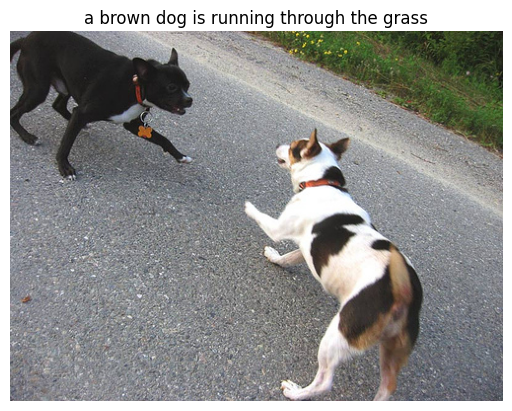

In [70]:
# Example image path (update accordingly)
image_path = "drive/MyDrive/Colabdata/Images/1001773457_577c3a7d70.jpg"

# Call function
display_image_with_caption(image_path, train_features, model, tokenizer, max_length, use_beam=True, beam_width=3)


In [67]:
print(list(test_features.keys())[:5])


['3136043366_b3f8607a0e.jpg', '2540751930_d71c7f5622.jpg', '3225226381_9fe306fb9e.jpg', '1557838421_a33f2a4911.jpg', '3400082864_9c737c1450.jpg']
